#1. Install dependencies:

In [1]:
%%capture --no-stderr
%pip install -U langchain_community langchain_google_genai langchain langchain_core tavily-python arxiv langgraph

In [2]:
import os
from google.colab import userdata

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = userdata.get(var)

_set_if_undefined("SERPER_API_KEY")
_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("GOOGLE_API_KEY")

#2. Define tools

In [3]:
import requests

def fetch_scopus_papers_test(query: str, count: int):
    """
    Fetches research papers from Scopus based on the provided search query.

    Args:
        query (str): The search query for fetching research papers from Scopus.
        api_key (str): Your Scopus API key.
        count (int): The number of research papers to fetch.

    Returns:
        list: A list of dictionaries containing details about each paper.
    """
    try:
        # Set up headers and query parameters for the API request
        headers = {
            'X-ELS-APIKey': userdata.get('SCOPUS_API_KEY'),
            'Accept': 'application/json'
        }
        params = {
            'query': query,
            'count': count
        }

        # Make the API request
        response = requests.get('https://api.elsevier.com/content/search/scopus', headers=headers, params=params)
        response.raise_for_status()  # Raise an error for bad status codes

        # Parse the JSON response
        data = response.json()
        papers = []

        for entry in data.get('search-results', {}).get('entry', []):
            paper_info = {
                'title': entry.get('dc:title'),
                'authors': entry.get('dc:creator'),
                'publicationName': entry.get('prism:publicationName'),
                'doi': entry.get('prism:doi'),
                'scopus_url': entry.get('link', [{}])[0].get('@href')
            }
            papers.append(paper_info)

        return papers

    except requests.exceptions.RequestException as e:
        return f"Failed to fetch papers. Error: {repr(e)}"

In [10]:
query = "machine learning"
count = 5

papers = fetch_scopus_papers_test(query, count)
for paper in papers:
    print(paper)

{'title': 'Circular Economy: A Bibliometric Review of Research in Emerging Economies (2010-2024)', 'authors': 'Uwuigbe U.', 'publicationName': 'International Journal of Energy Economics and Policy', 'doi': '10.32479/ijeep.17021', 'scopus_url': 'https://api.elsevier.com/content/abstract/scopus_id/85213806767'}
{'title': 'Real-Time Monitoring and Positioning of Agricultural Tractors Using a Low-Cost GPS and IoT Device', 'authors': 'Phasinam T.', 'publicationName': 'International Journal of Geoinformatics', 'doi': '10.52939/ijg.v21i1.3799', 'scopus_url': 'https://api.elsevier.com/content/abstract/scopus_id/85213954428'}
{'title': 'BIBLIOMETRIC ANALYSIS OF STUDIES ON INDUSTRY 4.0 MATURITY ASSESSMENT IN SMES', 'authors': 'Guimarães A.', 'publicationName': 'Millenium: Journal of Education, Technologies, and Health', 'doi': '10.29352/mill0216.e34672', 'scopus_url': 'https://api.elsevier.com/content/abstract/scopus_id/85213325707'}
{'title': 'Fuzzy logic application in the evaluation of energy

In [4]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool
from langchain_core.documents import Document
import requests

tavily_tool = TavilySearchResults(max_results=5)

@tool
def serper_tool(
    query: Annotated[str, "The search query for retrieving intermediate answers."]
):
    """Use this to perform a search query using the Google Serper API.
    Provide a concise query to retrieve relevant information."""
    try:
        search = GoogleSerperAPIWrapper()
        result = search.run(query)
    except BaseException as e:
        return f"Failed to execute search. Error: {repr(e)}"

    result_str = f"Successfully executed search:\nQuery: {query}\nResult: {result}"
    return (
        result_str
    )

@tool
def fetch_arxiv_papers(
    title: Annotated[str, "The title or keywords to search for in arXiv papers."],
    papers_count: Annotated[int, "The maximum number of papers to fetch."]
):
    """Fetches papers from arXiv based on the given title or keywords.
    Returns a list of papers with details including title, authors, summary, publication date, categories, and URLs."""
    try:
        import arxiv

        search_query = f'all:"{title}"'
        search = arxiv.Search(
            query=search_query,
            max_results=papers_count,
            sort_by=arxiv.SortCriterion.SubmittedDate,
            sort_order=arxiv.SortOrder.Descending
        )

        papers = []
        # Use the Client for searching
        client = arxiv.Client()

        # Execute the search
        search_results = client.results(search)

        for result in search_results:
            paper_info = {
                'title': result.title,
                'authors': [author.name for author in result.authors],
                'summary': result.summary,
                'published': result.published,
                'journal_ref': result.journal_ref,
                'doi': result.doi,
                'primary_category': result.primary_category,
                'categories': result.categories,
                'pdf_url': result.pdf_url,
                'arxiv_url': result.entry_id
            }
            papers.append(paper_info)

        return papers

    except BaseException as e:
        return f"Failed to fetch papers. Error: {repr(e)}"

@tool
def fetch_scopus_papers(
    query: Annotated[str, "The search query for fetching research papers from Scopus."],
    count: Annotated[int, "The number of research papers to fetch."]
):
    """Fetches research papers from Scopus based on the provided search query.
    Returns a list of papers with details including title, authors, publication name, and URLs."""
    try:
        headers = {
            'X-ELS-APIKey': userdata.get('SCOPUS_API_KEY'),
            'Accept': 'application/json'
        }
        params = {
            'query': query,
            'count': count
        }
        response = requests.get('https://api.elsevier.com/content/search/scopus', headers=headers, params=params)
        response.raise_for_status()  # Raise an error for bad status codes

        data = response.json()
        papers = []
        for entry in data.get('search-results', {}).get('entry', []):
            paper_info = {
                'title': entry.get('dc:title'),
                'authors': entry.get('dc:creator'),
                'publicationName': entry.get('prism:publicationName'),
                'doi': entry.get('prism:doi'),
                'scopus_url': entry.get('link', [{}])[0].get('@href')
            }
            papers.append(paper_info)

        return papers

    except requests.exceptions.RequestException as e:
        return f"Failed to fetch papers. Error: {repr(e)}"

#3. Define Assistant

In [5]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a specialized AI assistant focused on retrieving, analyzing, and summarizing scientific knowledge."
        " Collaborate with tools and other assistants to fetch and analyze research papers from sources such as Scopus,"
        " Scielo, Web of Science, and Arxiv. Provide valid and useful URLs, along with critical summaries of the papers."
        " Use the provided APIs and methods to search for relevant research. Ensure the information is accurate and"
        " well-cited. If the required research cannot be fully retrieved or analyzed, document your progress so another"
        " assistant can pick up from where you left off."
        " When the task is complete and all required deliverables are provided, prefix your response with FINAL ANSWER"
        " so the team knows the process is finalized."
        f"\n{suffix}"
    )

In [6]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [7]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")

def get_next_node(last_message: BaseMessage, goto: str):
    if goto == "FINAL ANSWER":
        # Any agent decided the work is done
        return END
    return goto

In [8]:
tavily_research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        """You are an expert on retrieving real research papers and their URLs from a given research topic from
        Web of Science, ResearchGate, Scielo or other valid research repositories."""
    ),
)

serper_research_agent = create_react_agent(
    llm,
    tools=[serper_tool],
    state_modifier=make_system_prompt(
        """You are an expert on retrieving real research papers and their URLs from a given research topic from
        Web of Science, ResearchGate, Scielo or other valid research repositories."""
    ),
)

arxiv_research_agent = create_react_agent(
    llm,
    tools=[fetch_arxiv_papers],
    state_modifier=make_system_prompt(
        """You are an expert on retrieving real research papers from a given research topic from Arxiv."""
    ),
)

scopus_research_agent = create_react_agent(
    llm,
    tools=[fetch_scopus_papers],
    state_modifier=make_system_prompt(
        """You are an expert on retrieving real research papers from a given research topic from Scopus."""
    )
)

In [44]:
from langchain.schema import (
       AIMessage,
       HumanMessage,
       SystemMessage
  )

def router_node(
    state: MessagesState,
) -> Command[Literal["tavily", "serper", "arxiv", "scopus"]]:

    messages = [
        SystemMessage(content="You are a routing assistant designed to determine the best platform for processing a user's query. Your task is to route the query to one of the following platforms: Tavily, Serper, Arxiv, or Scopus."),
        HumanMessage(content=f"""
    Based on the following query, determine the most suitable platform for obtaining relevant information:

    {state['messages'][-1].content}

    Criteria for routing:
    1. Route to **Arxiv** for academic queries that requires the access to Arxiv papers.
    2. Route to **Scopus** for academic queries that requires the access to Scopus papers.
    3. Route to **Serper** for other academic repositories like Web of Science, ResearchGate, SCielo and others.
    4. Route to **Tavily** for other academic repositories like Web of Science, ResearchGate, SCielo and others.

    Return only the name of the platform: `tavily`, `serper`, `arxiv` or `scopus`.
    """)
    ]

    result = llm.invoke(messages)

    decision = result.content.strip()

    goto = get_next_node(result, decision)

    result = HumanMessage(
        content=decision, name="router"
    )

    print(f"ROUTE NODE: {decision}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [10]:
def research_node(state: MessagesState, agent_name: str, agent) -> Command[Literal["format_paper_results"]]:
    """
    A generic node handler for research agents to avoid repetition and improve maintainability.

    Args:
        state: The current state of the messages.
        agent: The research agent's `invoke` method.
        agent_name: The name of the research agent (e.g., "tavily", "serper").

    Returns:
        A Command object with updated messages and the next node to transition to.
    """
    result = agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "format_paper_results")

    # Update the last message with the agent's name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name=agent_name
    )

    print(f"RESEARCH NODE: {result['messages'][-1].content}")

    return Command(
        update={
            "messages": result["messages"],  # Share internal message history with other agents
        },
        goto=goto,
    )

# Specific functions for each agent
def tavily_node(state: MessagesState) -> Command[Literal["format_paper_results"]]:
    return research_node(state, "tavily", tavily_research_agent)

def serper_node(state: MessagesState) -> Command[Literal["format_paper_results"]]:
    return research_node(state, "serper", serper_research_agent)

def arxiv_node(state: MessagesState) -> Command[Literal["format_paper_results"]]:
    return research_node(state, "arxiv", arxiv_research_agent)

def scopus_node(state: MessagesState) -> Command[Literal["format_paper_results"]]:
    return research_node(state, "scopus", scopus_research_agent)

In [11]:
from typing import List, Optional
from pydantic import BaseModel, Field

class ResearchPaperSchema(BaseModel):
    title: str = Field(..., description="The title of the research paper.")
    authors: List[str] = Field(..., description="A list of authors who contributed to the paper.")
    summary: str = Field(..., description="A brief summary or abstract of the paper.")
    published: str = Field(..., description="The publication date of the paper in ISO 8601 format (YYYY-MM-DD).")
    journal_ref: Optional[str] = Field(None, description="The reference to the journal where the paper is published, if available.")
    doi: Optional[str] = Field(None, description="The Digital Object Identifier (DOI) of the paper, if available.")
    primary_category: str = Field(..., description="The primary category of the paper, such as 'cs.AI'.")
    categories: List[str] = Field(..., description="A list of categories that the paper belongs to.")
    url: str = Field(..., description="The URL of the paper.")

class ListResearchPapers(BaseModel):
    papers: List[ResearchPaperSchema] = Field(..., description="A list of research papers.")

In [38]:
from langchain_core.output_parsers import JsonOutputParser

def format_paper_results(state: MessagesState) -> Command[Literal["perform_action"]]:
    json_parser = JsonOutputParser(pydantic_object=ListResearchPapers)

    messages = [
        SystemMessage(content="You are a data formatter tasked with organizing research paper information into a standardized schema."),
        HumanMessage(content=f"""Format the following extracted details of a research paper into the specified `ResearchPaperSchema`:

            {state['messages'][-1].content}

            Ensure the output includes the following fields:
            - `title`: The title of the research paper.
            - `authors`: A list of authors who contributed to the paper.
            - `summary`: A brief summary or abstract of the paper.
            - `published`: The publication date of the paper (YYYY-MM-DD).
            - `journal_ref` (optional): The reference to the journal where the paper is published, if available.
            - `doi` (optional): The Digital Object Identifier (DOI) of the paper, if available.
            - `primary_category`: The primary category of the paper (e.g., 'cs.AI').
            - `categories`: A list of categories that the paper belongs to.
            - `url`: The URL of the paper. THIS VALUE MUST NEVER BE null

            Use `null` for optional fields if the information is unavailable.

            The formatted response should adhere to the JSON format:
            {json_parser.get_format_instructions()}
        """)
    ]

    result = llm.invoke(messages)
    goto = get_next_node(result, "perform_action")

    # Update the last message with the agent's name
    result = HumanMessage(
        content=result.content, name="format_paper_results"
    )

    print(f"FORMAT PAPERS NODE: {result.content}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [13]:
class QAAnswerSchema(BaseModel):
    answer: str = Field(..., description="The main answer provided by the QA system.")
    confidence: float = Field(..., description="The confidence score of the answer, ranging from 0 to 1.")
    supporting_facts: List[str] = Field(
        ...,
        description="A list of supporting facts or statements extracted from the research papers to back up the answer."
    )
    reasoning: str = Field(
        ...,
        description="An explanation of how the answer was derived, including reasoning or logical steps."
    )
    context: str = Field(
        ...,
        description="The specific excerpt or paragraph from the research paper that supports the answer."
    )
    references: List[str] = Field(
        ...,
        description="A list of references (e.g., URLs, DOIs, or journal names) related to the answer."
    )
    retrieval_method: str = Field(
        ...,
        description="The method or strategy used to retrieve the answer (e.g., 'direct match', 'semantic search')."
    )
    additional_insights: str = Field(
        ...,
        description="Any additional insights, interpretations, or recommendations based on the answer."
    )

In [25]:
class FinalAnswerSchema(BaseModel):
    qa_answer: QAAnswerSchema
    research_papers: List[ResearchPaperSchema]

In [28]:
def perform_action(state: MessagesState) -> Command[Literal[END]]:
    json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)

    messages = [
        SystemMessage(content="You are an intelligent assistant tasked with answering user queries based on research papers, retrieving all relevant papers, and formatting responses in the user's language."),
        HumanMessage(content=f"""
    Answer the following query using information from all previously retrieved research papers. Format your response according to the `QAAnswerSchema` and ensure the response is in the language of the user's query.

    User query: {state['messages'][0].content}
    Research papers: {state['messages'][-1].content}

    Your response should include the following fields:
    1. **Answer**: Provide a clear and concise answer to the user's query.
    2. **Confidence** (optional): Indicate the confidence score of your answer (if applicable).
    3. **Supporting Facts** (optional): List key facts or statements from the research papers that back your answer.
    4. **Reasoning** (optional): Explain how the answer was derived, including reasoning or logical steps.
    5. **Context** (optional): Include excerpts or paragraphs from the research papers that support your answer.
    6. **References** (optional): Provide references such as URLs, DOIs, or journal names for further validation.
    7. **Retrieval Method** (optional): Indicate the method or strategy used to retrieve the answer (e.g., 'direct match', 'semantic search').
    8. **Additional Insights** (optional): Add any additional insights, interpretations, or recommendations based on the answer.

    Format your response as valid JSON:
    {json_parser.get_format_instructions()}

    Ensure the answer and all explanations are in the language of the query.
    """)
    ]

    result = llm.invoke(messages)
    goto = get_next_node(result, "FINAL ANSWER")

    # Update the last message with the agent's name
    result = HumanMessage(
        content=result.content, name="perform_action"
    )

    print(f"FINAL RESPONSE: {result.content}")

    return Command(
        update={
            "messages": result,
        },
        goto=goto,
    )

In [45]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("router", router_node)
workflow.add_node("tavily", tavily_node)
workflow.add_node("serper", serper_node)
workflow.add_node("arxiv", arxiv_node)
workflow.add_node("scopus", scopus_node)
workflow.add_node("format_paper_results", format_paper_results)
workflow.add_node("perform_action", perform_action)

workflow.add_edge(START, "router")
graph = workflow.compile()

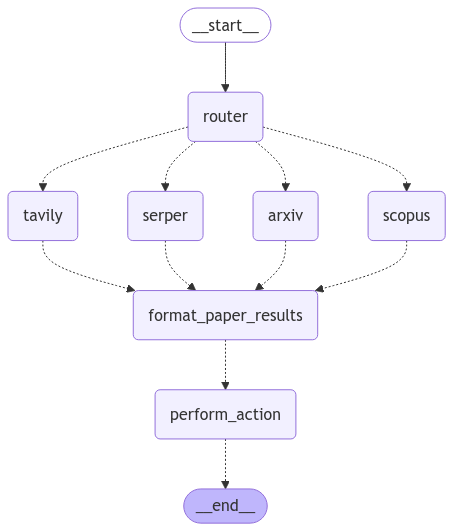

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Make an Essay about the research papers that you can obtain from Scopus about the following topic: Business Management with 5 papers"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: scopus
{'router': {'messages': HumanMessage(content='scopus', additional_kwargs={}, response_metadata={}, name='router', id='d4295f5d-8394-4def-90d1-145e4da8237c')}}
----
RESEARCH NODE: FINAL ANSWER
The search query "Business Management" on Scopus returned five research papers. However, it appears that the results are not directly related to core business management topics. Instead, they seem to focus on energy economics, environmental issues, and their intersection with tourism and technology. Here's a summary of the papers and their potential relevance to a broader understanding of business management:

**1. Does Energy Risk Lead to Tourism Fall in Europe? Insights from Partially Linear Functional-Coefficient Model**
   - **Authors:** Matyusupov B.
   - **Publication:** International Journal of Energy Economics and Policy
   - **DOI:** 10.32479/ijeep.18055
   - **URL:** https://api.elsevier.com/content/abstract/scopus_id/85213883393
   - **Summary:** This paper investigat

In [42]:
json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)
json_parser.parse(s['perform_action']['messages'].content)

{'qa_answer': {'answer': 'Claro, aquí tienes un ensayo sobre los documentos de investigación obtenidos de Scopus sobre el tema de Gestión Empresarial, utilizando 5 artículos:\n\n**Ensayo sobre Gestión Empresarial a partir de Investigaciones en Scopus**\n\nLa gestión empresarial es un campo dinámico que se ve influenciado por una variedad de factores, desde la economía global hasta las preocupaciones ambientales. Los documentos de investigación recientes obtenidos de Scopus ilustran esta complejidad, abordando temas como el riesgo energético, la innovación tecnológica, la inversión extranjera, la economía circular y el impacto del turismo. Estos estudios no solo resaltan los desafíos actuales, sino también las oportunidades para las empresas que buscan ser sostenibles y competitivas.\n\nUn artículo clave examina cómo el riesgo energético impacta el turismo en Europa. Este estudio, aunque no se enfoca directamente en la gestión empresarial, subraya la importancia de la planificación estr

In [46]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Give me the insights for 5 papers of Large Language Models from ResearchGate"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: serper
{'router': {'messages': HumanMessage(content='serper', additional_kwargs={}, response_metadata={}, name='router', id='2314f8a9-545c-47cf-a9a7-6bc97226828b')}}
----
RESEARCH NODE: Okay, I've found some papers related to Large Language Models on ResearchGate. Here are 5 papers with a brief insight for each:

1.  **Awesome-Multimodal-Large-Language-Models** (by S Yin, 2023): This paper provides a GitHub link (https://github.com/BradyFU/Awesome-Multimodal-Large-Language-Models) which is a collection of recent papers on multimodal large language models. It's a good resource for staying updated on the latest research in this area.

2.  **Personalizing Large Language Models (LLMs)** (by S Woźniak, 2024): This paper discusses the personalization of LLMs to align with individual user preferences and history. This is an important aspect of making LLMs more user-friendly and relevant.

3.  **Extracting Training Data from Large Language Models** (by M Pankiewicz, 2023): This pap

In [47]:
json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)
json_parser.parse(s['perform_action']['messages'].content)

{'qa_answer': {'answer': 'Aquí están los insights de 5 documentos de Modelos de Lenguaje Grandes (LLMs) de ResearchGate:\n\n1.  **Modelos de Lenguaje Multimodal Grandes:** Este documento proporciona un enlace de GitHub (https://github.com/BradyFU/Awesome-Multimodal-Large-Language-Models) que es una colección de documentos recientes sobre modelos de lenguaje multimodal grandes. Es un buen recurso para mantenerse actualizado sobre las últimas investigaciones en esta área.\n2.  **Personalización de LLMs:** Este documento analiza la personalización de LLMs para alinearse con las preferencias e historial de usuarios individuales. Este es un aspecto importante para hacer que los LLMs sean más fáciles de usar y relevantes.\n3.  **Extracción de Datos de Entrenamiento de LLMs:** Este documento se centra en la capacidad de los LLMs para procesar y extraer información de los datos. También aborda los métodos para extraer datos de entrenamiento de estos modelos, lo cual es crucial para comprender 

In [32]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Large Language Models in Arxiv"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: arxiv
{'router': {'messages': HumanMessage(content='arxiv', additional_kwargs={}, response_metadata={}, name='router', id='a44fcd38-ed8c-41cb-88f5-4bbd4d6d8fcd')}}
----
RESEARCH NODE: FINAL ANSWER: Here are the research papers I found on Arxiv related to Large Language Models:

1.  **Title:** ReFocus: Visual Editing as a Chain of Thought for Structured Image Understanding
    *   **Authors:** Xingyu Fu, Minqian Liu, Zhengyuan Yang, John Corring, Yijuan Lu, Jianwei Yang, Dan Roth, Dinei Florencio, Cha Zhang
    *   **Summary:** This paper introduces ReFocus, a framework that enhances multimodal LLMs by enabling them to generate "visual thoughts" through visual editing on input images. It allows the model to draw boxes, highlight sections, and mask areas, improving visual reasoning for tasks like interpreting tables and charts. The results show significant performance improvements over GPT-4o without visual editing.
    *   **Published:** 2025-01-09
    *   **URL:** [http://a

In [33]:
json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)
json_parser.parse(s['perform_action']['messages'].content)

{'qa_answer': {'answer': 'Los modelos de lenguaje grandes (LLMs) están siendo explorados en diversas áreas dentro de Arxiv, incluyendo el razonamiento multimodal, la detección de abuso cibernético, el análisis de sentimientos y la generación de código. Se están evaluando sus capacidades y limitaciones en diferentes contextos.',
  'confidence': 0.95,
  'supporting_facts': ['ReFocus mejora los LLMs multimodales mediante la edición visual en imágenes.',
   'EMMA evalúa el razonamiento multimodal de los MLLMs en diversas áreas.',
   'Un estudio analiza el abuso en redes sociales utilizando LMs y LLMs.',
   'Se usa Llama 3 8B para analizar sentimientos de microbloggers chinos.',
   'FairCode evalúa el sesgo social en la generación de código por LLMs.'],
  'reasoning': 'La respuesta se deriva de la información consolidada de los resúmenes de todos los artículos proporcionados. Cada artículo aborda un aspecto diferente de la aplicación y evaluación de LLMs, incluyendo su uso en tareas de razo

In [48]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "Give me the insights about the research papers that you can obtain from Scopus about the following topic: Philosophy with 5 papers"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: scopus
{'router': {'messages': HumanMessage(content='scopus', additional_kwargs={}, response_metadata={}, name='router', id='409d7087-15fd-4f78-80c8-395f1e4d57c8')}}
----
RESEARCH NODE: FINAL ANSWER
Here are the research papers from Scopus related to the topic "Philosophy":

1.  **Title:** On the Utility of Literary Fictions. An Approach from the Philosophy and Neuroscience of Narrative
    *   **Authors:** Buceta M.
    *   **Publication Name:** Tabano
    *   **DOI:** 10.46553/tab.25.2025.e10
    *   **URL:** [https://api.elsevier.com/content/abstract/scopus_id/85213453006](https://api.elsevier.com/content/abstract/scopus_id/85213453006)
    *   **Summary:** This paper explores the utility of literary fictions using insights from philosophy and neuroscience of narrative.

2.  **Title:** Resisting the hemlock. Philosophy in contemporary democracies
    *   **Authors:** Belgrano M.
    *   **Publication Name:** Tabano
    *   **DOI:** 10.46553/tab.25.2025.e8
    *   **URL:*

In [49]:
json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)
json_parser.parse(s['perform_action']['messages'].content)

{'qa_answer': {'answer': 'Aquí están los insights sobre los artículos de investigación con el tema de Filosofía, de un total de 5 artículos:\n\n1.  **La utilidad de las ficciones literarias:** Un artículo explora la utilidad de las ficciones literarias utilizando perspectivas de la filosofía y la neurociencia de la narrativa.\n2.  **La filosofía en las democracias contemporáneas:** Otro artículo discute el papel de la filosofía en las democracias contemporáneas, especialmente en la resistencia a influencias negativas.\n3.  **Educación ambiental, infancia y filosofía:** Un artículo investiga las posibilidades de encuentro entre la educación ambiental, la infancia, la filosofía y la escuela a través de experiencias filosóficas.\n\nAdemás, hay dos artículos de Economía que tienen relación con la filosofía:\n\n4.  **Transformación energética:** Un artículo examina el impacto de la transformación energética en la productividad económica y la sostenibilidad ambiental en Indonesia, que podría

In [50]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "RAG in Arxiv"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

ROUTE NODE: arxiv
{'router': {'messages': HumanMessage(content='arxiv', additional_kwargs={}, response_metadata={}, name='router', id='f8b8b02c-f31f-43f8-aca2-73a2e709d807')}}
----
RESEARCH NODE: FINAL ANSWER: Here are the Arxiv research papers related to RAG:

1.  **Title:** Search-o1: Agentic Search-Enhanced Large Reasoning Models
    *   **Authors:** Xiaoxi Li, Guanting Dong, Jiajie Jin, Yuyao Zhang, Yujia Zhou, Yutao Zhu, Peitian Zhang, Zhicheng Dou
    *   **Summary:** This paper introduces Search-o1, a framework that enhances Large Reasoning Models (LRMs) with an agentic retrieval-augmented generation (RAG) mechanism. It integrates an agentic search workflow into the reasoning process, enabling dynamic retrieval of external knowledge. A Reason-in-Documents module is designed to analyze the retrieved information, minimizing noise and preserving coherent reasoning flow.
    *   **URL:** [http://arxiv.org/abs/2501.05366v1](http://arxiv.org/abs/2501.05366v1)

2.  **Title:** RAG-WM: A

In [51]:
json_parser = JsonOutputParser(pydantic_object=FinalAnswerSchema)
json_parser.parse(s['perform_action']['messages'].content)

{'qa_answer': {'answer': 'RAG (Retrieval-Augmented Generation) is explored in several contexts within the provided Arxiv papers. These include enhancing reasoning models with agentic search (Search-o1), detecting IP infringement through watermarking (RAG-WM), improving biomedical relation extraction, enabling multimodal case-based reasoning (MCBR-RAG), and using context to guide smarter retrieval (SUGAR).',
  'confidence': 1.0,
  'supporting_facts': ['Search-o1 enhances Large Reasoning Models (LRMs) with an agentic retrieval-augmented generation (RAG) mechanism.',
   'RAG-WM is a black-box approach to detect IP infringement of RAGs using watermarks.',
   'A biomedical-specific RAG approach is used for document-level Bio-RE.',
   'MCBR-RAG is a general RAG framework for multimodal CBR applications.',
   'SUGAR leverages context-based entropy to actively decide whether to retrieve.'],
  'reasoning': 'The answer was derived by analyzing the summaries of each provided research paper. Each 